Firstly, necessary libraries are imported and versions of the libraries are printed. Then the dataset is loaded to pandas DataFrame. Data columns are renamed. 

In [124]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
import torch; print("Pytorch", torch.__version__)
import pandas; print("Pandas", torch.__version__)
import matplotlib.pyplot; print("Matplotlib", matplotlib.__version__)
import seaborn; print("Seaborn", seaborn.__version__)
import imblearn; print("imblearn", imblearn.__version__)
import skorch; print("skorch", skorch.__version__)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing


Windows-10-10.0.19041-SP0
Python 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
NumPy 1.19.1
SciPy 1.5.0
Scikit-Learn 0.23.0
Pytorch 1.7.1
Pandas 1.7.1
Matplotlib 3.3.1
Seaborn 0.11.0
imblearn 0.8.0
skorch 0.7.0


In [2]:
%time data = pd.read_csv('car.data', header = None)

print("Shape of the Data: ", data.shape )

data.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'decision']

Wall time: 5.02 ms
Shape of the Data:  (1728, 7)


Then, I checked the overall look of the data:

In [3]:
data.head()

,buying,maint,doors,persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Splitting the data

I splitted the data into train and test set to keep test set on the side and avoid data leakage after encoding.

In [4]:
y = data.values[:,-1].copy()
X = data.values[:,:-1].copy()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X , y , test_size = 0.20, random_state = 1)
X_test

array([['med', 'low', '3', 'more', 'small', 'low'],
       ['high', 'high', '3', 'more', 'big', 'med'],
       ['high', 'high', '5more', '2', 'med', 'med'],
       ...,
       ['vhigh', 'low', '4', '2', 'big', 'high'],
       ['vhigh', 'vhigh', '3', 'more', 'med', 'med'],
       ['vhigh', 'vhigh', '5more', '4', 'med', 'med']], dtype=object)

Then I formed a test DataFrame to save and keep it as a seperate sheet: 

In [5]:
test_file=pd.DataFrame()
test_file['buying']=X_test[:,0]
test_file['maint']=X_test[:,1]
test_file['doors']=X_test[:,2]
test_file['persons']=X_test[:,3]
test_file['lug_boot']=X_test[:,4]
test_file['safety']=X_test[:,5]
test_file['decision']=y_test
test_file

,buying,maint,doors,persons,lug_boot,safety,decision
0,med,low,3,more,small,low,unacc
1,high,high,3,more,big,med,acc
2,high,high,5more,2,med,med,unacc
3,low,med,3,2,big,med,unacc
4,high,med,5more,2,small,med,unacc
...,...,...,...,...,...,...,...
341,low,high,3,2,small,high,unacc
342,med,low,3,more,med,high,vgood
343,vhigh,low,4,2,big,high,unacc
344,vhigh,vhigh,3,more,med,med,unacc


In [6]:
test_file.to_csv("test_notebook_file.csv", index=False)

Checking splitting is all good:

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1382, 6), (1382,), (346, 6), (346,))

I also saved a dataframe version of the training target variable to make a distribution plot after:

In [103]:
y_train_df=pd.DataFrame(y_train)
y_train_df

,0
0,1
1,0
2,2
3,2
4,2
...,...
1377,0
1378,0
1379,0
1380,2


## Encoding variables

And go back to the training set, since most of the variables are categorical type, it is needed to be encoded to make classification analysis. Therefore I used OneHotEncoder to make predictors binary and numerical and LabelEncoder to make target variable numerical labels:

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

onehotencoder = OneHotEncoder()
X_train = onehotencoder.fit_transform(X_train).toarray()
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)

In [10]:
y_train, X_train

(array([1, 0, 2, ..., 0, 2, 2]),
 array([[0., 1., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 1., 0., 0.]]))

Now, training set is all numerical as seen above.

# Oversampling

Before making predictions for the target variable, it is crucial to check the distribution of our target variable. If it is unbalanced, our predictions can go wrong.

<AxesSubplot:>

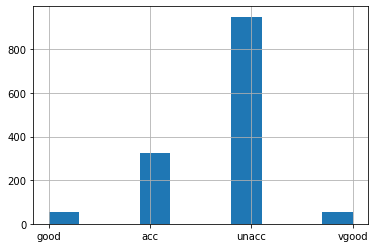

In [11]:
y_train_df[0].hist()

In [12]:
y_train_df[0].value_counts(normalize=True).mul(100).round(1)

unacc    68.7
acc      23.5
good      4.0
vgood     3.8
Name: 0, dtype: float64

As it is seen above, the target variable is quite unbalanced.

In [13]:
from collections import Counter
print(sorted(Counter(y_train).items()))

[(0, 325), (1, 55), (2, 950), (3, 52)]


When we match the category names and encoded numerical labels, we can say it is encoded as:
unacceptable: 2,
acceptable: 0,
good: 1,
very good: 3.

To rebalance our training target variable, we used SMOTE oversampling technique:

In [14]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 950), (1, 950), (2, 950), (3, 950)]


Looks like all classes of the target variable are equally numbered now to overcome misclassification.

As all variables are ready to classify, we can make modelling parts:

# MLP

Firstly, I will do Multilayer Perceptron(MLP) model for classification. Relevant libraries are imported: 

In [15]:
import torch.nn as nn
import torch.nn.functional as F
device = 'cpu'

Then I wrap the data with tensors. It is essential to make it to work with the Pytorch library for MLP.

In [16]:
X_train_torch = torch.FloatTensor(X_resampled)
y_train_torch = torch.LongTensor(y_resampled)

In [17]:
torch.bincount(y_train_torch)

tensor([950, 950, 950, 950])

Looks like it is wrapped correctly. 
Then, I form my multilayer perceptron neural network. It will be three layer: input layer, only one hidden layer since our data is not so complex and huge, and output layer. I set the hidden layer size as input size for the first experiment:

In [18]:
input_sz = X_train_torch.shape[1]
hidden_sz = input_sz
output_sz = y_train_torch.max().item()+1
print('input size: %d, hidden size: %d, output size: %d'%(input_sz,hidden_sz, output_sz))

input size: 21, hidden size: 21, output size: 4


Then I form my neural network classification class using object oriented structure:

In [70]:
class CarClassificationNN(nn.Module): #reference: lab 5
    
    def __init__(
            self,
            input_dim=input_sz,
            hidden_dim=hidden_sz,
            output_dim=output_sz,
            dropout=0.5,
    ):
        super(CarClassificationNN, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.tanh(self.hidden(x)) 
        x = self.dropout(x)
        x = F.softmax(self.output(x), dim=-1)
        return x

I have used tanh() activation function and softmax() function as my problem is classification type. The reason behind this usage is discussed on the report.

I use Skorch library to modeling. Skorch is very useful library to form a neural network model: 

In [71]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring

I use Early Stopping criterion to avoid overfitting as Early Stopping stops the training if there is no improvement for valid loss.

In [60]:
torch.manual_seed(0)
net = NeuralNetClassifier(
    CarClassificationNN,
    max_epochs=50,
    callbacks=[EarlyStopping()],
)

In [61]:
net.fit(X_train_torch, y_train_torch)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4389       0.2763        1.4108  0.0618
      2        1.4169       0.3013        1.3974  0.0618
      3        1.4094       0.3303        1.3845  0.0588
      4        1.3930       0.3395        1.3723  0.0618
      5        1.3818       0.3526        1.3602  0.0728
      6        1.3724       0.3632        1.3484  0.0549
      7        1.3605       0.3789        1.3371  0.0808
      8        1.3458       0.4000        1.3254  0.0568
      9        1.3387       0.4171        1.3137  0.0539
     10        1.3230       0.4342        1.3020  0.0678
     11        1.3080       0.4526        1.2902  0.0628
     12        1.3056       0.4737        1.2780  0.0648
     13        1.2836       0.5000        1.2654  0.0608
     14        1.2791       0.5263        1.2527  0.0668
     15        1.2610       0.5461        1.2396  0.0688
     16        1.2507       0.5

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CarClassificationNN(
    (dropout): Dropout(p=0.5, inplace=False)
    (hidden): Linear(in_features=21, out_features=21, bias=True)
    (output): Linear(in_features=21, out_features=4, bias=True)
  ),
)

In order to choose best parameters and hyperparameters, I make grid search model selection technique. It forms different models with several combination from the parameters which I enter.

I use different learning rates, hidden layer sizes, dropout values and optimisers. It is discussed detailed on the report.

Also I use stratified cross validation with grid search to make the model performance better and without bias.

In [23]:
# Grid Search
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.1, 0.01, 0.001],
    'module__hidden_dim':[11,21,42],
    'module__dropout':[0.5,0.8],
    'optimizer':[torch.optim.Adam, torch.optim.SGD],    
}
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
gs = GridSearchCV(net, params, refit=True, cv=kfold, scoring='accuracy', verbose=2)
gs.fit(X_train_torch, y_train_torch)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] lr=0.1, module__dropout=0.5, module__hidden_dim=11, optimizer=<class 'torch.optim.adam.Adam'> 
Re-initializing module because the following parameters were re-set: dropout, hidden_dim.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: dropout, hidden_dim.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.3180       0.2505        2.2844  0.0608
      2        3.8060       0.3176        1.5387  0.0728


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      3        2.1559       0.3945        1.2430  0.0888
      4        2.4150       0.4990        1.0052  0.0638
      5        1.4702       0.5779        0.8874  0.0578
      6        1.4813       0.6805        0.7107  0.0578
      7        1.3617       0.6667        0.7089  0.0658
      8        1.2553       0.8205        0.5516  0.0718
      9        1.1026       0.8817        0.4872  0.0668
     10        1.1669       0.8679        0.4226  0.0618
     11        1.2195       0.8284        0.5047  0.0598
     12        1.1914       0.9270        0.3374  0.0628
     13        1.0871       0.8955        0.4268  0.0838
     14        1.0376       0.8797        0.3667  0.0668
     15        1.0562       0.9349        0.3112  0.0618
     16        0.8567       0.9132        0.4341  0.0638
     17        1.1120       0.8836        0.3631  0.0668
     18        0.8539       0.9112        0.5155  0.0718
     19        1.3523       0.9053        0.3158  0.0559
Stopping since valid_loss has n

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


      3        2.5801       0.4241        1.1743  0.0638
      4        1.9737       0.3037        1.3623  0.0519
      5        2.3386       0.4990        1.0087  0.0568
      6        1.5850       0.3846        1.2269  0.0568
      7        1.9556       0.5838        0.8102  0.0688
      8        1.1554       0.4773        1.1089  0.0489
      9        2.0991       0.6312        0.7740  0.0539
     10        1.2427       0.5542        0.9350  0.0489
     11        1.6936       0.6864        0.6333  0.0598
     12        1.2848       0.6450        0.6603  0.0698
     13        1.2143       0.8028        0.5500  0.0598
     14        1.0590       0.7673        0.7526  0.0658
     15        1.5194       0.8225        0.4859  0.0698
     16        1.1143       0.8659        0.5707  0.0618
     17        1.0675       0.8836        0.4417  0.0598
     18        1.0494       0.9211        0.3636  0.0738
     19        0.8849       0.9053        0.3747  0.0648
     20        1.0162       0.9

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  5.5min finished


      3        1.0234       0.7184        0.8256  0.0868
      4        0.9051       0.7711        0.6897  0.0768
      5        0.7808       0.8132        0.5833  0.0798
      6        0.7063       0.8711        0.4946  0.0638
      7        0.6345       0.8908        0.4191  0.0808
      8        0.5722       0.9013        0.3590  0.0748
      9        0.5232       0.9053        0.3171  0.0698
     10        0.4942       0.9224        0.2815  0.0977
     11        0.4596       0.9355        0.2544  0.0808
     12        0.4253       0.9329        0.2380  0.0888
     13        0.4128       0.9474        0.2151  0.0808
     14        0.3991       0.9395        0.2110  0.0608
     15        0.3897       0.9526        0.1914  0.0858
     16        0.3526       0.9526        0.1850  0.0848
     17        0.3504       0.9579        0.1733  0.0818
     18        0.3370       0.9539        0.1693  0.0918
     19        0.3324       0.9618        0.1577  0.0868
     20        0.2986       0.9

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CarClassificationNN(
    (dropout): Dropout(p=0.5, inplace=False)
    (hidden): Linear(in_features=21, out_features=21, bias=True)
    (output): Linear(in_features=21, out_features=4, bias=True)
  ),
),
             param_grid={'lr': [0.1, 0.01, 0.001],
                         'module__dropout': [0.5, 0.8],
                         'module__hidden_dim': [11, 21, 42],
                         'optimizer': [<class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.sgd.SGD'>]},
             scoring='accuracy', verbose=2)

### Training vs Validation Loss Curves

According to grid search, I choose best estimator combination based on best parameters which are detected automatically by grid search. This is training vs validation loss curves with given epoch loop:

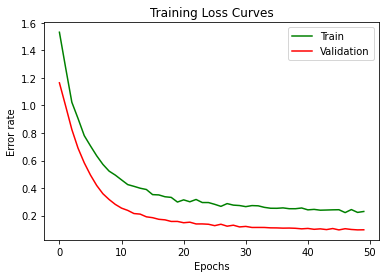

In [62]:
%matplotlib inline
# get training and validation loss
epochs = [i for i in range(len(gs.best_estimator_.history))]
train_loss = gs.best_estimator_.history[:,'train_loss']
valid_loss = gs.best_estimator_.history[:,'valid_loss']
plt.plot(epochs,train_loss,'g-')
plt.plot(epochs,valid_loss,'r-')
plt.title('Training Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Error rate')
plt.legend(['Train','Validation'])

It looks like our model is good fit according to shape of the curve. It is discussed on the report.

Then I have a look at the grid search results as a sheet.

In [86]:
gridsearchMLP=pd.DataFrame(gs.cv_results_)
gridsearchMLP

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_module__dropout,param_module__hidden_dim,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.586750,0.980956,0.020611,0.002050,0.1,0.5,11,<class 'torch.optim.adam.Adam'>,"{'lr': 0.1, 'module__dropout': 0.5, 'module__h...",0.936069,0.961326,0.872038,0.923144,0.037580,9
1,3.761943,0.121078,0.025930,0.003551,0.1,0.5,11,<class 'torch.optim.sgd.SGD'>,"{'lr': 0.1, 'module__dropout': 0.5, 'module__h...",0.895817,0.910813,0.915482,0.907371,0.008389,14
2,1.951448,0.425166,0.022939,0.004534,0.1,0.5,21,<class 'torch.optim.adam.Adam'>,"{'lr': 0.1, 'module__dropout': 0.5, 'module__h...",0.960537,0.939227,0.944708,0.948157,0.009035,7
3,3.763604,0.047998,0.020944,0.000814,0.1,0.5,21,<class 'torch.optim.sgd.SGD'>,"{'lr': 0.1, 'module__dropout': 0.5, 'module__h...",0.902131,0.909234,0.906003,0.905790,0.002904,16
4,1.738351,0.379095,0.026928,0.005086,0.1,0.5,42,<class 'torch.optim.adam.Adam'>,"{'lr': 0.1, 'module__dropout': 0.5, 'module__h...",0.726125,0.854775,0.936809,0.839236,0.086710,23
5,3.857021,0.050107,0.028923,0.004953,0.1,0.5,42,<class 'torch.optim.sgd.SGD'>,"{'lr': 0.1, 'module__dropout': 0.5, 'module__h...",0.907656,0.915549,0.913112,0.912106,0.003300,13
6,2.340741,0.079417,0.028258,0.003290,0.1,0.8,11,<class 'torch.optim.adam.Adam'>,"{'lr': 0.1, 'module__dropout': 0.8, 'module__h...",0.722178,0.921863,0.710900,0.784981,0.096900,24
7,3.474538,0.044166,0.024268,0.002488,0.1,0.8,11,<class 'torch.optim.sgd.SGD'>,"{'lr': 0.1, 'module__dropout': 0.8, 'module__h...",0.880821,0.889503,0.884676,0.885000,0.003552,19
8,2.520594,0.323342,0.032912,0.001628,0.1,0.8,21,<class 'torch.optim.adam.Adam'>,"{'lr': 0.1, 'module__dropout': 0.8, 'module__h...",0.729282,0.930545,0.946288,0.868705,0.098796,20
9,3.542196,0.429490,0.025265,0.009851,0.1,0.8,21,<class 'torch.optim.sgd.SGD'>,"{'lr': 0.1, 'module__dropout': 0.8, 'module__h...",0.887924,0.887135,0.894155,0.889738,0.003140,18


I saved the grid search record as an Excel sheet for further reference for the report:

In [109]:
gridsearchMLP.to_csv("gridsearchMLP.csv", index=False)

I will find out at the best parameters to figure out and use them to remodelling:

In [87]:
gs.best_params_

{'lr': 0.01,
 'module__dropout': 0.5,
 'module__hidden_dim': 11,
 'optimizer': torch.optim.adam.Adam}

I set the best parameters as model parameters and form it, then cross validate it best scores:

In [90]:
import torch.optim as optim
torch.manual_seed(0)

net_final = NeuralNetClassifier(
    CarClassificationNN(),
    max_epochs=50,
    callbacks=[EarlyStopping()],
    lr=0.01,
    optimizer=torch.optim.Adam
)

#Since dropout is already 0.5 on our CarClassificationNN, we have not change it here.


from sklearn.model_selection import cross_validate
scores = cross_validate(net_final, X_train_torch, y_train_torch, scoring='accuracy', cv=5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8270       0.3470        1.3662  0.0469
      2        1.2922       0.7418        1.1573  0.0479
      3        1.1527       0.7911        0.9270  0.0608
      4        0.9395       0.8141        0.7183  0.0628
      5        0.7713       0.8816        0.5664  0.0568
      6        0.6388       0.9046        0.4576  0.0648
      7        0.5753       0.9046        0.3823  0.0608
      8        0.4934       0.9062        0.3322  0.0708
      9        0.4389       0.9095        0.2992  0.0588
     10        0.4164       0.9145        0.2710  0.0549
     11        0.3923       0.9161        0.2513  0.0489
     12        0.3606       0.9211        0.2314  0.0499
     13        0.3438       0.9211        0.2262  0.0439
     14        0.3427       0.9276        0.2060  0.0499
     15        0.3134       0.9260        0.2004  0.0559
     16        0.2917       0.9

Then the scores of cross validation is analysed:

In [91]:
scores

{'fit_time': array([3.46170998, 3.66719556, 3.2722497 , 3.10469723, 3.64525461]),
 'score_time': array([0.01196837, 0.01396203, 0.01296639, 0.01097059, 0.01894712]),
 'test_score': array([0.97368421, 0.96973684, 0.96842105, 0.95131579, 0.97368421])}

Test score mean of the validation:

In [108]:
np.mean([0.97368421, 0.96973684, 0.96842105, 0.95131579, 0.97368421])

0.96736842

Then I save my model using pickle library:

In [85]:
import pickle
with open('mlp_model.pkl', 'wb') as f:
    pickle.dump(net_final, f)
    
net_final.initialize()
net_final.save_params(
    f_params='model.pkl', f_optimizer='opt.pkl', f_history='history.json')


Now, lets do an alternative fitting with the imbalanced data, before SMOTE for the comparison with the best model selection:

In [112]:
X_train_t= torch.FloatTensor(X_train)
y_train_t= torch.LongTensor(y_train)
scores_alternative = cross_validate(net_final, X_train_t, y_train_t, scoring='accuracy', cv=5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3042       0.6878        0.9869  0.0259
      2        0.8979       0.6878        0.7904  0.0189
      3        0.7917       0.6878        0.6960  0.0269
      4        0.7022       0.7828        0.5993  0.0220
      5        0.6041       0.7873        0.5004  0.0189
      6        0.5078       0.8597        0.4287  0.0269
      7        0.4485       0.8824        0.3803  0.0180
      8        0.4135       0.8688        0.3437  0.0209
      9        0.3693       0.9005        0.3115  0.0180
     10        0.3499       0.8959        0.2837  0.0229
     11        0.3149       0.9050        0.2612  0.0160
     12        0.2961       0.9140        0.2436  0.0189
     13        0.2736       0.9186        0.2297  0.0170
     14        0.2715       0.9276        0.2151  0.0239
     15        0.2620       0.9321        0.2037  0.0249
     16        0.2561       0.9

In [113]:
scores_alternative

{'fit_time': array([1.44812465, 1.52791452, 1.37631869, 1.2347002 , 1.10305214]),
 'score_time': array([0.00598502, 0.00698256, 0.00498724, 0.00498414, 0.00598478]),
 'test_score': array([0.93862816, 0.9566787 , 0.92753623, 0.94202899, 0.94202899])}

In [114]:
np.mean([0.93862816, 0.9566787 , 0.92753623, 0.94202899, 0.94202899])

0.9413802139999999

# SVM

Relevant libraries are imported:

In [51]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
clf=OneVsRestClassifier(SVC(probability=True)).fit(X_resampled, y_resampled)

For model selection, grid search is conducted with 3 folds stratified cross validation with selected hyperparameters:

In [52]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
parameters = {
    "estimator__C": [0.05, 0.1,0.5, 1, 5],
    "estimator__kernel": ["poly","linear"],
    "estimator__gamma": [5, 1, 0.5, 0.05, 0.01]
}

grid_search = GridSearchCV(clf, parameters, verbose = 3, scoring='accuracy' ,refit=True, n_jobs=-1, cv=kfold)

grid_search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   35.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=OneVsRestClassifier(estimator=SVC(probability=True)),
             n_jobs=-1,
             param_grid={'estimator__C': [0.05, 0.1, 0.5, 1, 5],
                         'estimator__gamma': [5, 1, 0.5, 0.05, 0.01],
                         'estimator__kernel': ['poly', 'linear']},
             scoring='accuracy', verbose=3)

Grid search is analysed through as a sheet:

In [54]:
gridsearchSVM=pd.DataFrame(grid_search.cv_results_)
gridsearchSVM

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__gamma,param_estimator__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.669538,0.042592,0.036566,1.243334e-03,0.05,5,poly,"{'estimator__C': 0.05, 'estimator__gamma': 5, ...",0.998421,0.998421,0.999210,0.998684,0.000372,3
1,2.027245,0.025883,0.108377,1.695825e-03,0.05,5,linear,"{'estimator__C': 0.05, 'estimator__gamma': 5, ...",0.853197,0.864246,0.851501,0.856315,0.005651,43
2,1.693803,0.039613,0.041889,8.104673e-07,0.05,1,poly,"{'estimator__C': 0.05, 'estimator__gamma': 1, ...",0.996054,0.998421,0.996051,0.996842,0.001117,13
3,2.037551,0.085588,0.109374,4.017366e-03,0.05,1,linear,"{'estimator__C': 0.05, 'estimator__gamma': 1, ...",0.853197,0.864246,0.851501,0.856315,0.005651,43
4,2.046195,0.020217,0.067486,1.243900e-03,0.05,0.5,poly,"{'estimator__C': 0.05, 'estimator__gamma': 0.5...",0.982636,0.988161,0.979463,0.983420,0.003594,15
5,2.075783,0.069032,0.110704,4.534071e-03,0.05,0.5,linear,"{'estimator__C': 0.05, 'estimator__gamma': 0.5...",0.853197,0.864246,0.851501,0.856315,0.005651,43
6,3.751635,0.017940,0.229386,8.143934e-04,0.05,0.05,poly,"{'estimator__C': 0.05, 'estimator__gamma': 0.0...",0.859511,0.852407,0.868088,0.860002,0.006411,40
7,2.098057,0.035367,0.110704,1.410739e-03,0.05,0.05,linear,"{'estimator__C': 0.05, 'estimator__gamma': 0.0...",0.853197,0.864246,0.851501,0.856315,0.005651,43
8,3.333088,0.041032,0.224733,3.083398e-03,0.05,0.01,poly,"{'estimator__C': 0.05, 'estimator__gamma': 0.0...",0.868982,0.816890,0.857030,0.847634,0.022280,50
9,2.078775,0.065715,0.110039,2.859982e-03,0.05,0.01,linear,"{'estimator__C': 0.05, 'estimator__gamma': 0.0...",0.853197,0.864246,0.851501,0.856315,0.005651,43


In [104]:
gridsearchSVM.to_csv("gridsearchSVM.csv", index=False)

Cross validation scores are analysed with best estimator hyperparameters:

In [55]:
scores = cross_validate(grid_search.best_estimator_, X_resampled, y_resampled, scoring='accuracy', cv=5)

In [56]:
scores

{'fit_time': array([0.98137355, 0.98333836, 1.02525997, 0.97544217, 0.98042345]),
 'score_time': array([0.01196623, 0.0119679 , 0.01296568, 0.01391315, 0.0119679 ]),
 'test_score': array([0.99868421, 0.99736842, 0.99868421, 0.99868421, 0.99736842])}

Finding out best estimators of SVM:

In [57]:
grid_search.best_estimator_

OneVsRestClassifier(estimator=SVC(C=1, gamma=0.5, kernel='poly',
                                  probability=True))

Saving the best model via pickle library for reusing in the test side:

In [58]:
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

Plotting learning curve to analyse learning regime of the selected model:

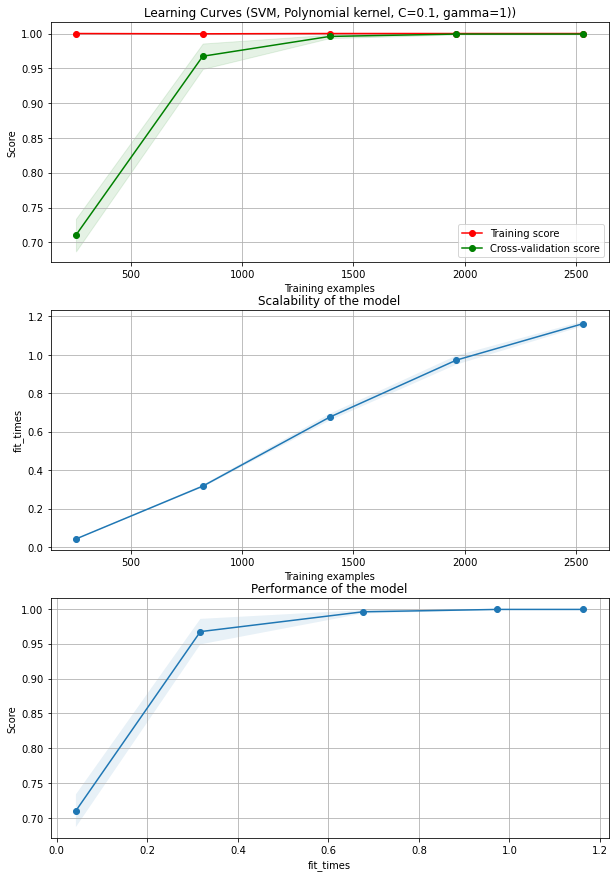

In [59]:
#reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = r"Learning Curves (SVM, Polynomial kernel, C=0.1, gamma=1))"

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

plot_learning_curve(grid_search.best_estimator_, title, X_resampled, y_resampled, axes, cv=cv, n_jobs=-1)

plt.show()